In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Initialization of Constants
P_thruster = 1250000 #newtons
P_lift = 1400000 #newtons
P_weight = 500000 #newtons

alpha = 5 #degrees
alpha = alpha * np.pi/180
EC_11 = 148.24e9 #Pascals, AS4 Axial Young's Modulus
EC_22 = 10.07e9 #Pascals, AS4 Transverse Young's Modulus
vC_12 = 0.3 # Major in-plane Poisson's ratio
vC_21 = EC_22*vC_12/EC_11 # Minor in-plane Poisson's ratio
GC_12 = 5.58e9 #Gigapascals, Shear Modulus 

EAl = 69.69e9 #Pascals

R_c = 1.5
R_a = 1.495
R_i = 1.49
L = 20 # meters



In [4]:
# Determining Axial Stiffness, S
def getE(beta):
    beta = beta * np.pi/180 #converting degrees to radians
    
    # Reduced Stiffness Matrix in Local Coordinates
    Q = np.array([[(EC_11)/(1-vC_12*vC_21), (vC_21*EC_11)/(1-vC_12*vC_21), 0], 
                  [(vC_12*EC_22)/(1-vC_12*vC_21), (EC_22)/(1-vC_12*vC_21), 0],
                  [0, 0, GC_12]])

    # Reuter's Matrix
    R = np.array([[1,0,0],[0,1,0],[0,0,2]]) 
    
    # Rotation Matrix
    T = np.array([[np.cos(beta)**2, np.sin(beta)**2, 2*np.sin(beta)*np.cos(beta)],
                 [np.sin(beta)**2, np.cos(beta)**2,-2*np.sin(beta)*np.cos(beta)],
                 [-1*np.sin(beta)*np.cos(beta), np.sin(beta)*np.cos(beta),np.cos(beta)**2 - np.sin(beta)**2]])
    
    # Reduced Stiffness Matrix in Global Coordinates
    Q_bar = np.matmul(np.linalg.inv(T), np.matmul(Q, np.matmul(R, np.matmul(T,np.linalg.inv(R)))))

    S_bar = np.linalg.inv(Q_bar)

    E_axial = 1/S_bar[0,0]
    return E_axial

E_layers = np.array([getE(0), getE(45), getE(-45), getE(90), getE(90), getE(-45), getE(45), getE(0)]) 

# Equations for P1 & P2 (Horizontal and Vertical Resultant Forces)
P1 = P_lift*np.sin(alpha) - P_thruster
P2 = P_lift*np.cos(alpha) - P_weight*np.cos(alpha)

# Calculates Axial Stiffness (S) for each layer and sums them for total S
# iterate from the outer radius in
r = R_c
S = 0
i = 0
numLayers = 8
while i < numLayers:
    S = S + (E_layers[i]) * np.pi * (r**2 - (r - 0.005/8)**2)
    r = r - 0.005/8
    i = i + 1
S = S + np.pi * EAl * (R_a**2 - R_i**2)
print(f"Value of S for laminate and aluminium is: {S:.4g} N/m")

# Calculating Bending Stiffness
H_33 = 0
r = R_c
i = 0
while i < numLayers: 
    H_33 = H_33 + E_layers[i] * np.pi * (r**4 - (r - 0.005/8)**4)/4
    r = r - 0.005/8
    i = i + 1
H_33 = H_33 + EAl * np.pi * (R_a**4 - R_i**4)/4
print(f"Value of H_33 is: {H_33:.4g} N/m")

# Axial Displacement
x1 = np.linspace(0,20,50)
u1 = (P_lift*np.sin(alpha)*x1 - P_thruster*x1)/S

# Axial Strain
eps1 = (P_lift*np.sin(alpha) - P_thruster)/S

# Axial Stress due to Axial Load
sigma_axial = np.zeros(len(E_layers))
for i in range(len(E_layers)):
    sigma_axial[i] = E_layers[i] * (P_lift*np.sin(alpha) - P_thruster)/S
sigma_axial_Al = EAl * (P_lift*np.sin(alpha) - P_thruster)/S
sigma_axial = np.append(sigma_axial, sigma_axial_Al)

# M3max at x1=0
M3 = -P_weight*np.cos(alpha)*(L-5) + P_lift*np.cos(alpha)*L
print(round(M3,3))

# Axial Stress due to Bending in each layer
r = np.arange(1.499375,1.494375,-0.000625)
sigma = np.zeros(len(E_layers))
for i in range(len(sigma)): 
    sigma[i] = (-E_layers[i] * r[i] * M3)/H_33

sigmaAl = EAl * R_i * M3/H_33
sigma = np.append(sigma, sigmaAl)
print(sigma)


Value of S for laminate and aluminium is: 5.464e+09 N/m
Value of H_33 is: 6.102e+09 N/m
20421991.311
[-7.43839560e+08 -7.13435682e+07 -7.13138169e+07 -5.04661183e+07
 -5.04450557e+07 -7.12245631e+07 -7.11948118e+07 -7.41669123e+08
  3.47504420e+08]


Text(0, 0.5, 'Bending Moment')

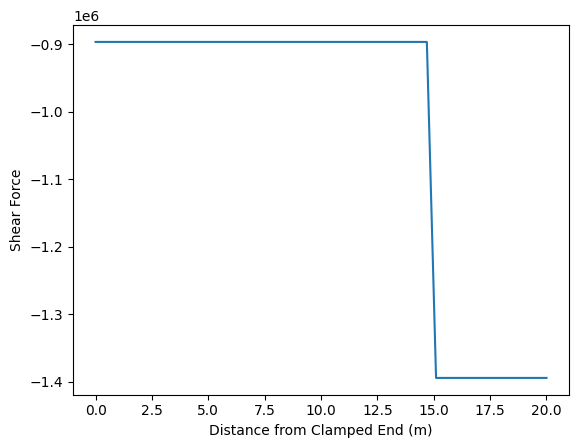

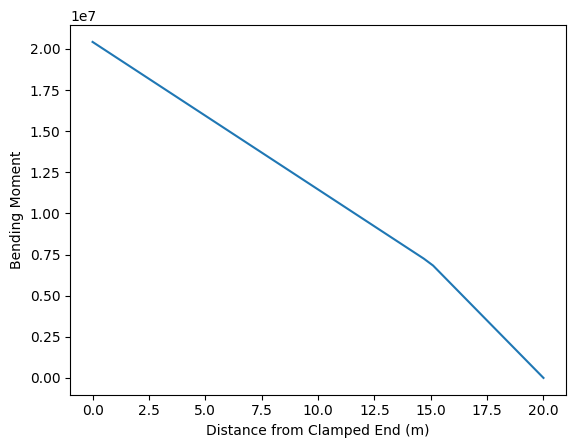

In [5]:
# Shear Diagram
x1 = np.linspace(0,20,50)
y1 = np.piecewise(x1, [x1<=15, x1>15], 
                 [lambda x1:  -P_lift*np.cos(alpha) + P_weight*np.cos(alpha), 
                  lambda x1: -P_lift*np.cos(alpha)])


# Bending moment diagram 
y2 = np.piecewise(x1, [x1<15, x1>=15],
                 [lambda x1: -P_weight*np.cos(alpha)*(L-5-x1) + P_lift*np.cos(alpha)*(L-x1), 
                  lambda x1: P_lift*np.cos(alpha)*(L-x1)])

plt.figure()
plt.plot(x1,y1)
#plt.title("Shear Moment Diagram")
plt.xlabel("Distance from Clamped End (m)")
plt.ylabel("Shear Force")

plt.figure()
plt.plot(x1,y2)
#plt.title("Bending Moment Diagram")
plt.xlabel("Distance from Clamped End (m)")
plt.ylabel("Bending Moment")

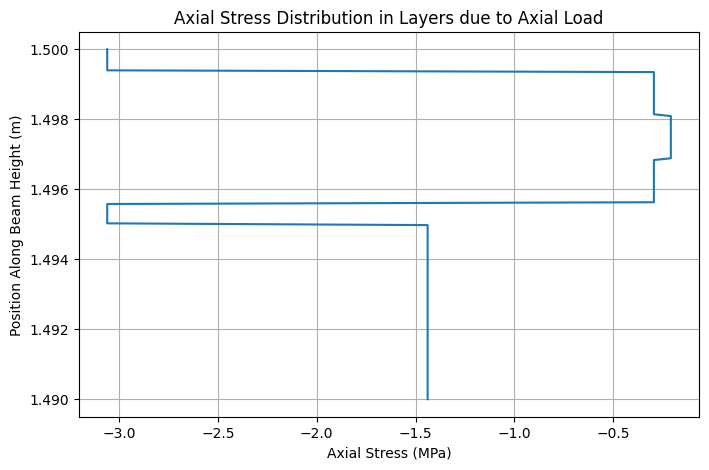

In [6]:
# PLOT 1
# Plot of Axial stress distribution due to the axial load (compression) 
# Position Along Beam Height vs. Top Axial Stress

x2 = np.linspace(R_i, R_c,200)
layerNum = 0
r = R_a + 0.005/8
i = 0
axial = []
for x in x2:
    if x < R_a:
        axial.append(sigma_axial_Al/10e6)
    if x >= R_a and x < (r):
        axial.append(sigma_axial[i]/10e6)
    if x > r:
        r = r + 0.005/8
        i = i + 1
        axial.append(sigma_axial[i]/10e6)

plt.figure(figsize=(8, 5))
plt.plot(axial,x2)
plt.ylabel("Position Along Beam Height (m)")
plt.xlabel("Axial Stress (MPa)")
plt.title("Axial Stress Distribution in Layers due to Axial Load")
plt.grid()
plt.show()

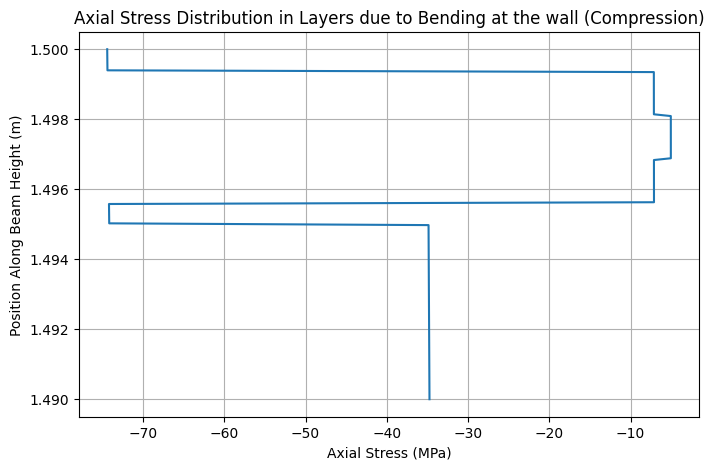

In [7]:
# PLOT 2
# Plot of axial stress distribution due to the Bending at the Wall (compression) 
# Position Along Beam Height vs. Axial Stress Due to Bending

x2 = np.linspace(R_i, R_c,200)
layerNum = 0
r = R_a + 0.005/8
i = 0
sigma = []
for x in x2:
    if x < R_a:
        sigma.append(-EAl*x*M3/H_33/10e6)
    if x >= R_a and x < (r):
        sigma.append(-E_layers[i]*x*M3/H_33/10e6)
    if x > r:
        r = r + 0.005/8
        i = i + 1
        sigma.append(-E_layers[i]*x*M3/H_33/10e6)

plt.figure(figsize=(8, 5))
plt.plot(sigma,x2)
plt.ylabel("Position Along Beam Height (m)")
plt.xlabel("Axial Stress (MPa)")
plt.title("Axial Stress Distribution in Layers due to Bending at the wall (Compression)")
plt.grid()
plt.show()

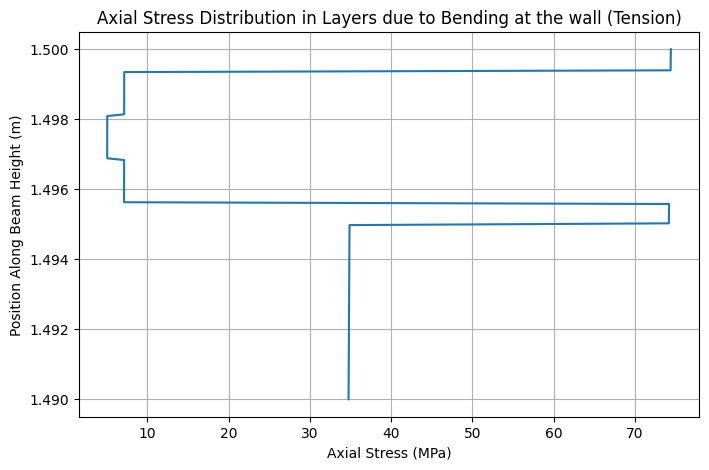

In [8]:
# PLOT 3
# Plot of axial stress distribution due to the Bending at the Wall (tension) 
# Position Along Beam Height vs. Axial Stress Due to Bending

x2 = np.linspace(R_i, R_c,200)
layerNum = 0
r = R_a + 0.005/8
i = 0
sigma2 = []
for x in x2:
    if x < R_a:
        sigma2.append(EAl*x*M3/H_33/10e6)
    if x >= R_a and x < (r):
        sigma2.append(E_layers[i]*x*M3/H_33/10e6)
    if x > r:
        r = r + 0.005/8
        i = i + 1
        sigma2.append(E_layers[i]*x*M3/H_33/10e6)

plt.figure(figsize=(8, 5))
plt.plot(sigma2,x2)
plt.ylabel("Position Along Beam Height (m)")
plt.xlabel("Axial Stress (MPa)")
plt.title("Axial Stress Distribution in Layers due to Bending at the wall (Tension)")
plt.grid()
plt.show()

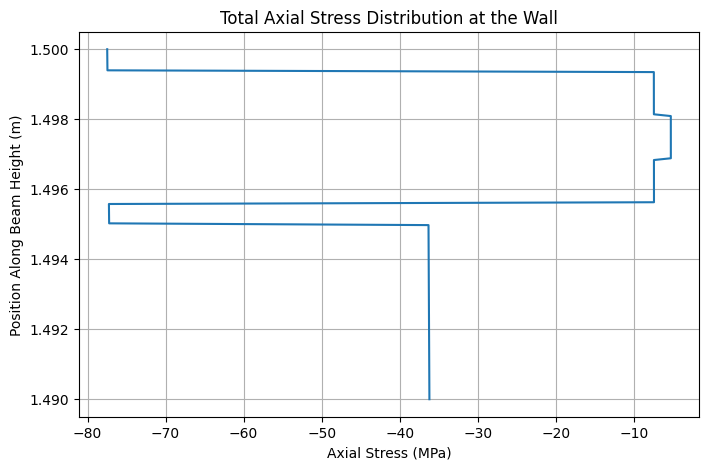

In [27]:
# PLOT 4
# Plot the total axial stress distribution at the wall (Compression) 
# Position Along Beam Height versus total axial stress

total_sigma = np.zeros(len(sigma))
#Top_sigma = np.zeros(len(sigma))
Bot_sigma = np.zeros(len(sigma))

for i in range(len(sigma)): 
    total_sigma[i] = +sigma[i] + axial[i]
    #Top_sigma[i] = total_sigma[i]
    Bot_sigma[i] = sigma2[i] + axial[i]


plt.figure(figsize=(8, 5))
plt.plot(total_sigma,x2)
plt.ylabel("Position Along Beam Height (m)")
plt.xlabel("Axial Stress (MPa)")
plt.title("Total Axial Stress Distribution at the Wall")
plt.grid()
plt.show()


[-1268.635  -168.23   -168.23   -168.23   -168.23   -168.23   -168.23
 -1268.635]


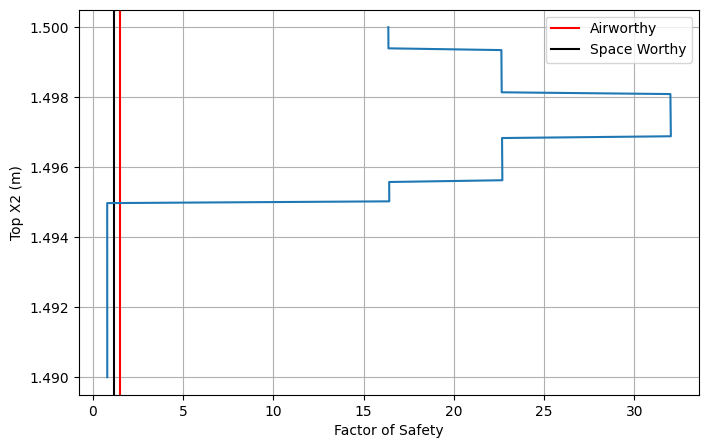

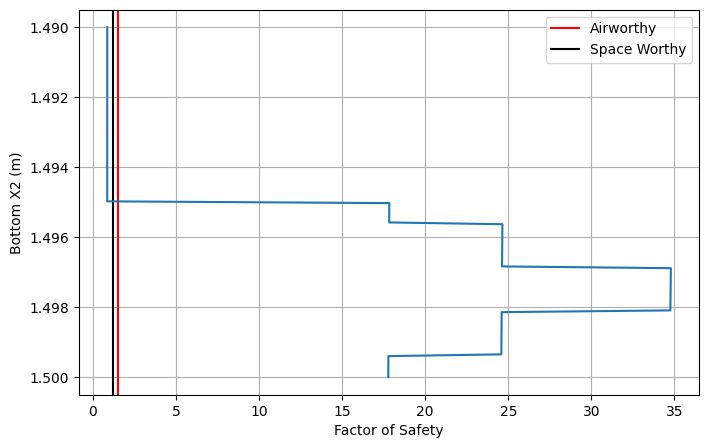

In [28]:
# PLOT 5
# Plot the Factor of Safety the wall (Compression) 
# X2

# PLOT 4
# Plot the total axial stress distribution at the wall (Compression) 
# Position Along Beam Height versus total axial stress
x2 = np.linspace(R_i, R_c,200)
r = R_a + 0.005/8


def getS(layupAngle):
    S_AS4 = [-1268.635, -168.23, -168.23, -168.23]#MPa
    #We will only work with fibers in 0,+/-45,90,
    if layupAngle in range(0,45):
        return S_AS4[0]
    if layupAngle in range(45,90):
        return S_AS4[1]
    if layupAngle == 90:
        return S_AS4[2]
    if layupAngle in range(-45,0):
        return S_AS4[3]
    
S_layers = np.array([getS(0), getS(45), getS(-45), getS(90), getS(90), getS(-45), getS(45), getS(0)]) 

#for i in range(len(x2))

S_al = 289.6 #MPa
print(S_layers)
SFTOP = []
SFBOT = []
j = 0
for i in range(len(x2)):
    #print(i)
    if x2[i] < R_a:
        SFTOP.append(S_al/total_sigma[i]/10)
        SFBOT.append(S_al/Bot_sigma[i]/10)
        #print(total_sigma[i])
        #print(SF)
    if x2[i] >= R_a and x2[i] < (r):
        SFTOP.append(S_layers[j]/total_sigma[i])
        SFBOT.append(S_layers[j]/Bot_sigma[i])


    if x2[i] > r:
        r = r + 0.005/8
        j = j + 1
        SFTOP.append(S_layers[j]/total_sigma[i])
        
        SFBOT.append(S_layers[j]/Bot_sigma[i])

plt.figure(figsize=(8, 5))
#plt.xlim([0,max(SFTOP)+1])
plt.axvline(x = 1.5, color = 'red',label = 'Airworthy') 
plt.axvline(x = 1.2, color = 'black', label = 'Space Worthy')
plt.plot(np.abs(SFTOP),x2)
plt.ylabel("Top X2 (m)")
plt.xlabel("Factor of Safety")
#plt.title("Factor of Safety at the Wall")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
#plt.xlim([0,max(SFBOT)+1])
plt.axvline(x = 1.5, color = 'red', label = 'Airworthy') 
plt.axvline(x = 1.2, color = 'black', label = 'Space Worthy')
plt.plot(np.abs(SFBOT),x2)
plt.gca().invert_yaxis()
plt.ylabel("Bottom X2 (m)")
plt.xlabel("Factor of Safety")
#plt.title("Factor of Safety at the Wall")
plt.legend()
plt.grid()
plt.show()



# hello 